# Recommender Systems 2017/18

### Practice 11 - Using different learning schedules with LightFM

##### The following notebook is available at [LightFM Github repo](https://github.com/lyst/lightfm)

# Using different learning schedules
`lightfm` implements two learning schedules: adagrad and adadelta. Neither is clearly superior, and, like other hyperparameter choices, the best learning schedule will differ based on the problem at hand.

This example tries both at the Movielens 100k dataset.

## Preliminaries
Let's first get the data and define the evaluations functions.

In [1]:
import numpy as np
#import data

%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from lightfm import LightFM
from lightfm.datasets import fetch_movielens
from lightfm.evaluation import auc_score

movielens = fetch_movielens()

train, test = movielens['train'], movielens['test']

/anaconda3/lib/python3.6/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn('LightFM was compiled without OpenMP support. '


In [2]:
import traceback, os
import scipy.sparse
import pandas as pd
import numpy as np

URM_all = scipy.sparse.load_npz('../Matrix/URM_all_matrix.npz')
ICM_all = scipy.sparse.load_npz('../Matrix/ICM_all_matrix.npz')
URM_train = scipy.sparse.load_npz('../Matrix/URM_train_matrix.npz')
URM_test = scipy.sparse.load_npz('../Matrix/URM_test_matrix.npz')



#Load playlistsIDS
train_df= pd.read_csv('../all/train.csv',low_memory = False)
all_userID=train_df.playlist_id.unique()

In [47]:
def selection_sort(x):
    for i in range(len(x)):
        swap = i + np.argmin(x[i:])
        (x[i], x[swap]) = (x[swap], x[i])
    return x

In [48]:
all_trackID=train_df.track_id.unique()
selection_sort(all_trackID)
print(all_trackID)
print(all_userID.shape)

<class 'numpy.ndarray'>
(50446,)


In [60]:
print(all_trackID.max())

20634


In [3]:
train=URM_train
test=URM_test

In [13]:
NUM_THREADS = 4
NUM_COMPONENTS = 30
NUM_EPOCHS = 5
ITEM_ALPHA = 1e-6
LEARNING_RATE = 0.005
LEARNING_SCHEDULE = 'adagrad'
RANDOM_SEED = 29031994    

warp_model = LightFM(loss='warp',
                    learning_rate=LEARNING_RATE,
                    learning_schedule=LEARNING_SCHEDULE,
                    item_alpha=ITEM_ALPHA,
                    no_components=NUM_COMPONENTS,
                    random_state=RANDOM_SEED)

bpr_model = LightFM(loss='bpr',
                    learning_rate=LEARNING_RATE,
                    learning_schedule=LEARNING_SCHEDULE,
                    item_alpha=ITEM_ALPHA,
                    no_components=NUM_COMPONENTS,
                    random_state=RANDOM_SEED)

In [22]:
import itertools

import numpy as np

from lightfm import LightFM
from lightfm.evaluation import precision_at_k


def sample_hyperparameters():
    """
    Yield possible hyperparameter choices.
    """

    while True:
        yield {
            "no_components": np.random.randint(16, 64),
            "learning_schedule": np.random.choice(["adagrad", "adadelta"]),
            "loss": np.random.choice(["bpr", "warp", "warp-kos"]),
            "learning_rate": np.random.exponential(0.05),
            "item_alpha": np.random.exponential(1e-8),
            "user_alpha": np.random.exponential(1e-8),
            "max_sampled": np.random.randint(5, 15),
            "num_epochs": np.random.randint(5, 50),
        }


def random_search(train, test, num_samples=10, num_threads=1):
    """
    Sample random hyperparameters, fit a LightFM model, and evaluate it
    on the test set.

    Parameters
    ----------

    train: np.float32 coo_matrix of shape [n_users, n_items]
        Training data.
    test: np.float32 coo_matrix of shape [n_users, n_items]
        Test data.
    num_samples: int, optional
        Number of hyperparameter choices to evaluate.


    Returns
    -------

    generator of (auc_score, hyperparameter dict, fitted model)

    """

    for hyperparams in itertools.islice(sample_hyperparameters(), num_samples):
        num_epochs = hyperparams.pop("num_epochs")

        model = LightFM(**hyperparams)
        model.fit(train, epochs=num_epochs, num_threads=num_threads)

        score = precision_at_k(model, test, train, k=10).mean()

        hyperparams["num_epochs"] = num_epochs

        yield (score, hyperparams, model)


if __name__ == "__main__":

    train=URM_train
    test=URM_test

    (score, hyperparams, model) = max(random_search(train, test, num_threads=2), key=lambda x: x[0])

    print("Best score {} at {}".format(score, hyperparams))

Best score 0.05861927196383476 at {'no_components': 33, 'learning_schedule': 'adadelta', 'loss': 'warp-kos', 'learning_rate': 0.025257881135407268, 'item_alpha': 3.1398099520730376e-09, 'user_alpha': 9.433349737893364e-09, 'max_sampled': 14, 'num_epochs': 40}


## Experiment
To evaluate the performance of both learning schedules, let's create two models and run each for a number of epochs, measuring the ROC AUC on the test set at the end of each epoch.

In [4]:
epochs = 1000
components=250

adagrad_model = LightFM(no_components=components,
                        loss='warp',
                        learning_schedule='adagrad',
                        learning_rate=0.01)

adagrad_model.fit(train, epochs=epochs,num_threads=6, verbose=True)

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50
Epoch 51
Epoch 52
Epoch 53
Epoch 54
Epoch 55
Epoch 56
Epoch 57
Epoch 58
Epoch 59
Epoch 60
Epoch 61
Epoch 62
Epoch 63
Epoch 64
Epoch 65
Epoch 66
Epoch 67
Epoch 68
Epoch 69
Epoch 70
Epoch 71
Epoch 72
Epoch 73
Epoch 74
Epoch 75
Epoch 76
Epoch 77
Epoch 78
Epoch 79
Epoch 80
Epoch 81
Epoch 82
Epoch 83
Epoch 84
Epoch 85
Epoch 86
Epoch 87
Epoch 88
Epoch 89
Epoch 90
Epoch 91
Epoch 92
Epoch 93
Epoch 94
Epoch 95
Epoch 96
Epoch 97
Epoch 98
Epoch 99
Epoch 100
Epoch 101
Epoch 102
Epoch 103
Epoch 104
Epoch 105
Epoch 106
Epoch 107
Epoch 108
Epoch 109
Epoch 110


Epoch 831
Epoch 832
Epoch 833
Epoch 834
Epoch 835
Epoch 836
Epoch 837
Epoch 838
Epoch 839
Epoch 840
Epoch 841
Epoch 842
Epoch 843
Epoch 844
Epoch 845
Epoch 846
Epoch 847
Epoch 848
Epoch 849
Epoch 850
Epoch 851
Epoch 852
Epoch 853
Epoch 854
Epoch 855
Epoch 856
Epoch 857
Epoch 858
Epoch 859
Epoch 860
Epoch 861
Epoch 862
Epoch 863
Epoch 864
Epoch 865
Epoch 866
Epoch 867
Epoch 868
Epoch 869
Epoch 870
Epoch 871
Epoch 872
Epoch 873
Epoch 874
Epoch 875
Epoch 876
Epoch 877
Epoch 878
Epoch 879
Epoch 880
Epoch 881
Epoch 882
Epoch 883
Epoch 884
Epoch 885
Epoch 886
Epoch 887
Epoch 888
Epoch 889
Epoch 890
Epoch 891
Epoch 892
Epoch 893
Epoch 894
Epoch 895
Epoch 896
Epoch 897
Epoch 898
Epoch 899
Epoch 900
Epoch 901
Epoch 902
Epoch 903
Epoch 904
Epoch 905
Epoch 906
Epoch 907
Epoch 908
Epoch 909
Epoch 910
Epoch 911
Epoch 912
Epoch 913
Epoch 914
Epoch 915
Epoch 916
Epoch 917
Epoch 918
Epoch 919
Epoch 920
Epoch 921
Epoch 922
Epoch 923
Epoch 924
Epoch 925
Epoch 926
Epoch 927
Epoch 928
Epoch 929
Epoch 930


It looks like the adadelta gets to a better result at the beginning of training. However, as we keep running more epochs adagrad wins out, converging to a better final solution.

In [51]:
from lightfm.evaluation import precision_at_k


precision_at_k(adagrad_model, test, train, k=10).mean()

0.07558909

In [65]:
prova=adagrad_model.predict(0,all_trackID)
print(prova)

[ 1.85123765 -1.66329038  0.80811316 ... -1.77228475 -0.91775233
 -0.96937263]


In [64]:
#uno per volta predico tutti gli utenti e estraggo dalla lista dei ratings per ogni canzone
ratings_matrix=np.zeros((50446,20635))

for u in all_userID:
    if (u==1000):
        print("Blocco")
    if (u==5000):
        print("BloccoX")
    if (u==10000):
        print("Blocco1")
    if (u==20000):
        print("Blocco2")
    if (u==30000):
        print("Blocco3")
    if (u==40000):
        print("Blocco4")
    if (u==50000):
        print("Blocco5")
    rec[u]=adagrad_model.predict(0,all_trackID)
    for x in all_trackID:
        ratings_matrix[u,x]=adagrad_model.predict(u,x)
print(ratings_matrix)  

KeyboardInterrupt: 

In [ ]:
a=ratings_matrix[0]
bestTen=sorted(range(len(a)), key=lambda i: a[i])[-10:]
print(bestTen)

In [ ]:
import numpy as np
import scipy.sparse as sps



def precision(is_relevant, relevant_items):

    #is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)

    precision_score = np.sum(is_relevant, dtype=np.float32) / len(is_relevant)

    return precision_score



def recall(is_relevant, relevant_items):

    #is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)

    recall_score = np.sum(is_relevant, dtype=np.float32) / relevant_items.shape[0]

    return recall_score



def MAP(is_relevant, relevant_items):

    #is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)

    # Cumulative sum: precision at 1, at 2, at 3 ...
    p_at_k = is_relevant * np.cumsum(is_relevant, dtype=np.float32) / (1 + np.arange(is_relevant.shape[0]))

    map_score = np.sum(p_at_k) / np.min([relevant_items.shape[0], is_relevant.shape[0]])

    return map_score

In [ ]:
def evaluate_algorithm(URM_test, recMatrix, at=10):

    cumulative_precision = 0.0
    cumulative_recall = 0.0
    cumulative_MAP = 0.0

    num_eval = 0

    URM_test = sps.csr_matrix(URM_test)

    n_users = URM_test.shape[0]


    for user_id in range(n_users):

        if user_id % 10000 == 0:
            print("Evaluated user {} of {}".format(user_id, n_users))

        start_pos = URM_test.indptr[user_id]
        end_pos = URM_test.indptr[user_id+1]

        if end_pos-start_pos>0:

            relevant_items = URM_test.indices[start_pos:end_pos]
            
            a=recMatrix[user_id]
        
            recommended_items = sorted(range(len(a)), key=lambda i: a[i])[-10:]
            num_eval+=1

            is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)

            cumulative_precision += precision(is_relevant, relevant_items)
            cumulative_recall += recall(is_relevant, relevant_items)
            cumulative_MAP += MAP(is_relevant, relevant_items)


    cumulative_precision /= num_eval
    cumulative_recall /= num_eval
    cumulative_MAP /= num_eval

    print("Recommender performance is: Precision = {:.4f}, Recall = {:.4f}, MAP = {:.4f}".format(
        cumulative_precision, cumulative_recall, cumulative_MAP))

    result_dict = {
        "precision": cumulative_precision,
        "recall": cumulative_recall,
        "MAP": cumulative_MAP,
    }

    return result_dict

In [ ]:
evaluate_algorithm(URM_test,ratings_matrix)

We can try the same for the k-OS loss.

In [4]:
alpha = 1e-3
epochs = 70

adagrad_model = LightFM(no_components=30,
                        loss='warp-kos',
                        learning_schedule='adagrad',
                        user_alpha=alpha, item_alpha=alpha)
adadelta_model = LightFM(no_components=30,
                        loss='warp-kos',
                        learning_schedule='adadelta',
                        user_alpha=alpha, item_alpha=alpha)

adagrad_auc = []

for epoch in range(epochs):
    adagrad_model.fit_partial(train, epochs=1)
    adagrad_auc.append(auc_score(adagrad_model, test).mean())
    
    
adadelta_auc = []

for epoch in range(epochs):
    adadelta_model.fit_partial(train, epochs=1)
    adadelta_auc.append(auc_score(adadelta_model, test).mean())

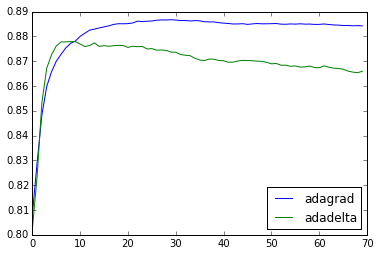

In [5]:
x = np.arange(len(adagrad_auc))
plt.plot(x, np.array(adagrad_auc))
plt.plot(x, np.array(adadelta_auc))
plt.legend(['adagrad', 'adadelta'], loc='lower right')
plt.show()